In [ ]:
# standard libraries
import numpy as np
import matplotlib.pyplot as plt

# additional libraries
import pandas as pd
import seaborn as sns
from pandas import read_pickle
from tqdm import tqdm

# Scikit-learn 
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.preprocessing import LabelEncoder

# Imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

# TensorFlow / Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from keras.models import Model
from keras.layers import Embedding, Dense, Input, LSTM

In [ ]:
df = pd.read_pickle('path/Dataset/New_Preprocessed_Dataset.pkl')

df_gan = read_pickle('path/Dataset/GAN_DF.pkl')

In [ ]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('path/GloVe/glove.6B.200d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:15, 25818.55it/s]

Found 400000 word vectors.


In [4]:
X = df['text'].tolist()
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [5]:
all_texts = list(X_train) + list(X_test) + list(df_gan["text"])
token = Tokenizer(num_words=None, oov_token="<OOV>")
max_len = 40
token.fit_on_texts(all_texts)

In [6]:
xtrain_pad = sequence.pad_sequences(token.texts_to_sequences(X_train), maxlen=max_len)
xvalid_pad = sequence.pad_sequences(token.texts_to_sequences(X_test), maxlen=max_len)
xtrain_pad_gan = sequence.pad_sequences(token.texts_to_sequences(list(X_train) + list(df_gan["text"])), maxlen=max_len)

In [ ]:
# encoding labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
y_train_gan = list(y_train) + list(df_gan["label"])
y_train_enc_gan = le.transform(y_train_gan)


In [8]:
word_index = token.word_index
embedding_matrix = np.zeros((len(word_index) + 1, 200))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 15356/15356 [00:00<00:00, 415000.95it/s]


In [ ]:
oov_words = []

for word in word_index:
    if word not in embeddings_index:
        oov_words.append(word)

print(f"Nombre de mots dans le vocabulaire : {len(word_index)}")
print(f"Nombre de mots OOV (non présents dans GloVe) : {len(oov_words)}")
print(f"Pourcentage OOV : {100 * len(oov_words) / len(word_index):.2f}%")

Nombre de mots dans le vocabulaire : 15356
Nombre de mots OOV (non présents dans GloVe) : 2117
Pourcentage OOV : 13.79%


In [ ]:
def evaluate_model(model, x_test_pad, y_test_enc, model_name="Model", class_names=["normal", "racism", "sexism"], cmap="Blues"):

    # Predict probabilities
    y_pred_probs = model.predict(x_test_pad)

    # Convert probabilities to class predictions
    y_pred = np.argmax(y_pred_probs, axis=1)

    # If class names not provided, auto-generate from unique labels
    if class_names is None:
        class_names = [str(c) for c in sorted(np.unique(y_test_enc))]

    # Metrics
    accuracy = round(accuracy_score(y_test_enc, y_pred), 2)
    precision = round(precision_score(y_test_enc, y_pred, average='weighted', zero_division=0), 2)
    recall = round(recall_score(y_test_enc, y_pred, average='weighted', zero_division=0), 2)
    f1 = round(f1_score(y_test_enc, y_pred, average='weighted', zero_division=0), 2)

    # Display results
    print(f"\n--- Results for {model_name} ---")

    # Raw confusion matrix
    cm = confusion_matrix(y_test_enc, y_pred)
    print("Confusion matrix (raw values):")

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix ({model_name})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.grid(False)
    plt.show()

    # Percentage confusion matrix
    cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
    cm_percent = np.round(cm_percent, 1)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap=cmap, cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix ({model_name}) - Percentages (%)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.grid(False)
    plt.show()

    # Classification report
    print("\nClassification report:")
    print(classification_report(y_test_enc, y_pred, zero_division=0, target_names=class_names))

    # Summary metrics
    print(f"Accuracy : {accuracy}")
    print(f"Precision : {precision}")
    print(f"Recall : {recall}")
    print(f"F1-score : {f1}")

    return None

In [10]:
def simple_lstm_model(vocab_size, embedding_matrix, max_len):
    input_layer = Input(shape=(max_len,))
    embedding_layer = Embedding(
        input_dim=vocab_size,
        output_dim=200,
        weights=[embedding_matrix],
        trainable=False
    )(input_layer)
    rnn1 = LSTM(100, return_sequences=True)(embedding_layer)
    rnn2 = LSTM(50)(rnn1)
    output_layer = Dense(3, activation='sigmoid')(rnn2)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_lstm = simple_lstm_model(len(word_index) + 1, embedding_matrix, max_len)

### With ROS

In [12]:
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(xtrain_pad, y_train_enc)

#### LSTM

In [13]:
model_lstm_ros = simple_lstm_model(len(word_index) + 1, embedding_matrix, max_len)
model_lstm_ros.fit(X_train_ros, y_train_ros, epochs=5, batch_size=32)

Epoch 1/5
682/682 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.7086 - loss: 0.6405
Epoch 2/5
682/682 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.8174 - loss: 0.4266
Epoch 3/5
682/682 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.8770 - loss: 0.3129
Epoch 4/5
682/682 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.9212 - loss: 0.2177
Epoch 5/5
682/682 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.9580 - loss: 0.1341


147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

--- Results for LSTM with ROS ---
Confusion matrix (raw values):


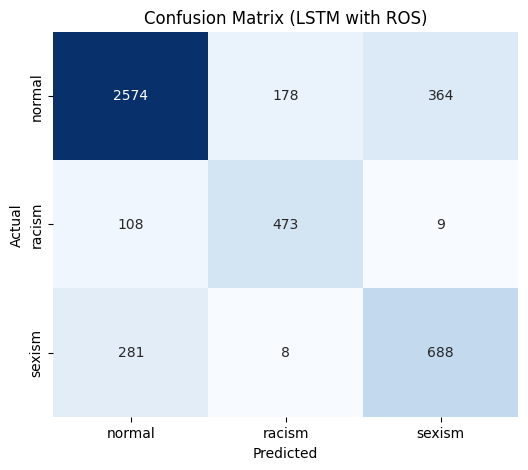

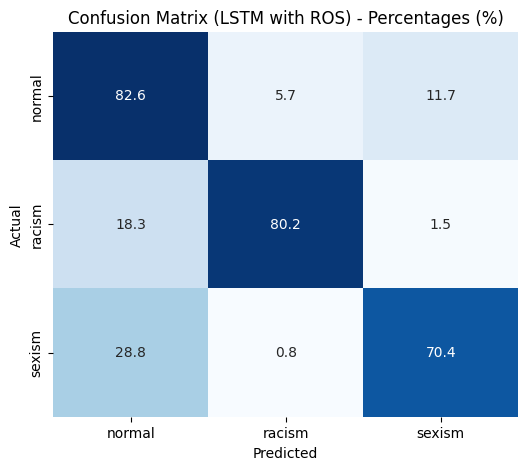


Classification report:
              precision    recall  f1-score   support

      normal       0.87      0.83      0.85      3116
      racism       0.72      0.80      0.76       590
      sexism       0.65      0.70      0.68       977

    accuracy                           0.80      4683
   macro avg       0.74      0.78      0.76      4683
weighted avg       0.80      0.80      0.80      4683

Accuracy : 0.8
Precision : 0.8
Recall : 0.8
F1-score : 0.8


In [14]:
evaluate_model(model_lstm_ros, xvalid_pad, y_test_enc, model_name="LSTM with ROS")

## With GAN

In [15]:
model_lstm_gan = simple_lstm_model(len(word_index) + 1, embedding_matrix, max_len)
model_lstm_gan.fit(xtrain_pad_gan, y_train_enc_gan, epochs=5, batch_size=32)

Epoch 1/5
545/545 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.7402 - loss: 0.5788
Epoch 2/5
545/545 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.8473 - loss: 0.3661
Epoch 3/5
545/545 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.8807 - loss: 0.2956
Epoch 4/5
545/545 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.8916 - loss: 0.2632
Epoch 5/5
545/545 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9156 - loss: 0.2140


147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step

--- Results for LSTM with GAN ---
Confusion matrix (raw values):


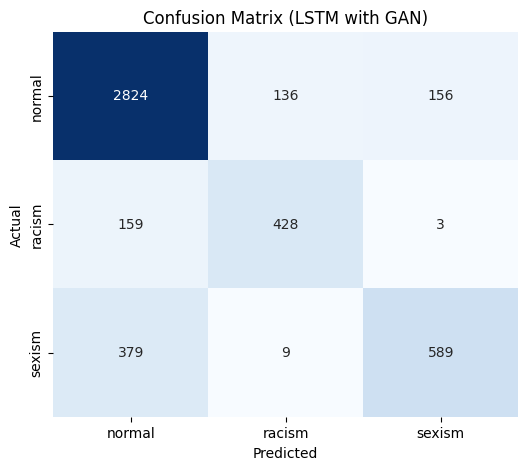

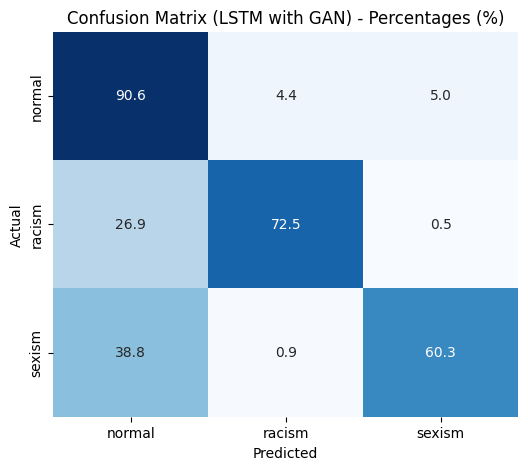


Classification report:
              precision    recall  f1-score   support

      normal       0.84      0.91      0.87      3116
      racism       0.75      0.73      0.74       590
      sexism       0.79      0.60      0.68       977

    accuracy                           0.82      4683
   macro avg       0.79      0.74      0.76      4683
weighted avg       0.82      0.82      0.82      4683

Accuracy : 0.82
Precision : 0.82
Recall : 0.82
F1-score : 0.82


In [16]:
evaluate_model(model_lstm_gan, xvalid_pad, y_test_enc, model_name="LSTM with GAN")

### Without augmentation

In [17]:
model_lstm_no = simple_lstm_model(len(word_index) + 1, embedding_matrix, max_len)
model_lstm_no.fit(xtrain_pad, y_train_enc, epochs=5, batch_size=32)

Epoch 1/5
342/342 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.7241 - loss: 0.6505
Epoch 2/5
342/342 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.7975 - loss: 0.4901
Epoch 3/5
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8231 - loss: 0.4341
Epoch 4/5
342/342 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8377 - loss: 0.3999
Epoch 5/5
342/342 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8445 - loss: 0.3742


147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step

--- Results for LSTM without augmentation ---
Confusion matrix (raw values):


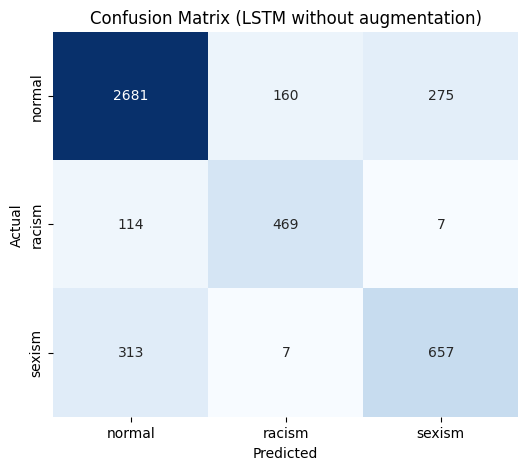

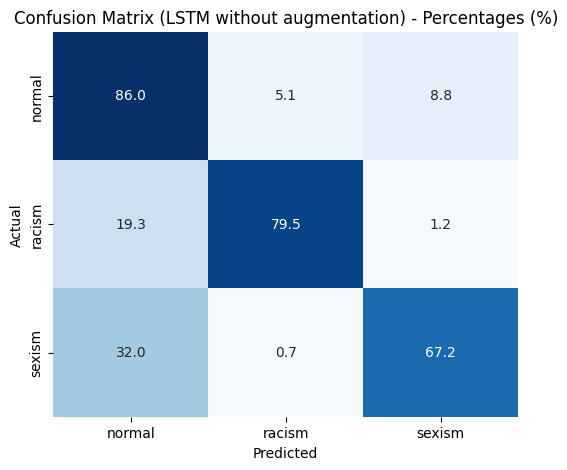


Classification report:
              precision    recall  f1-score   support

      normal       0.86      0.86      0.86      3116
      racism       0.74      0.79      0.77       590
      sexism       0.70      0.67      0.69       977

    accuracy                           0.81      4683
   macro avg       0.77      0.78      0.77      4683
weighted avg       0.81      0.81      0.81      4683

Accuracy : 0.81
Precision : 0.81
Recall : 0.81
F1-score : 0.81


In [18]:
evaluate_model(model_lstm_no, xvalid_pad, y_test_enc, model_name="LSTM without augmentation")